In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import rotate
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.metrics import peak_signal_noise_ratio as PSNR
from scipy import signal


def gaussian_filter(n_rows, n_cols, stdv):
    """
    Returns a 2d Gaussian image filter.
    """
    g_r = signal.windows.gaussian(n_rows, stdv)
    g_c = signal.windows.gaussian(n_cols, stdv)

    G = np.outer(g_r, g_c)

    return G/np.sum(G)

plt.gray()
lena= rgb2gray(imread('lena.tiff'))
frequnoisy = imread('frequnoisy.tif').astype(np.float64)/255

<Figure size 640x480 with 0 Axes>

# 2. Fourier Analysis

In [2]:
f = np.zeros((256,256))
f[:,107:148] = 1

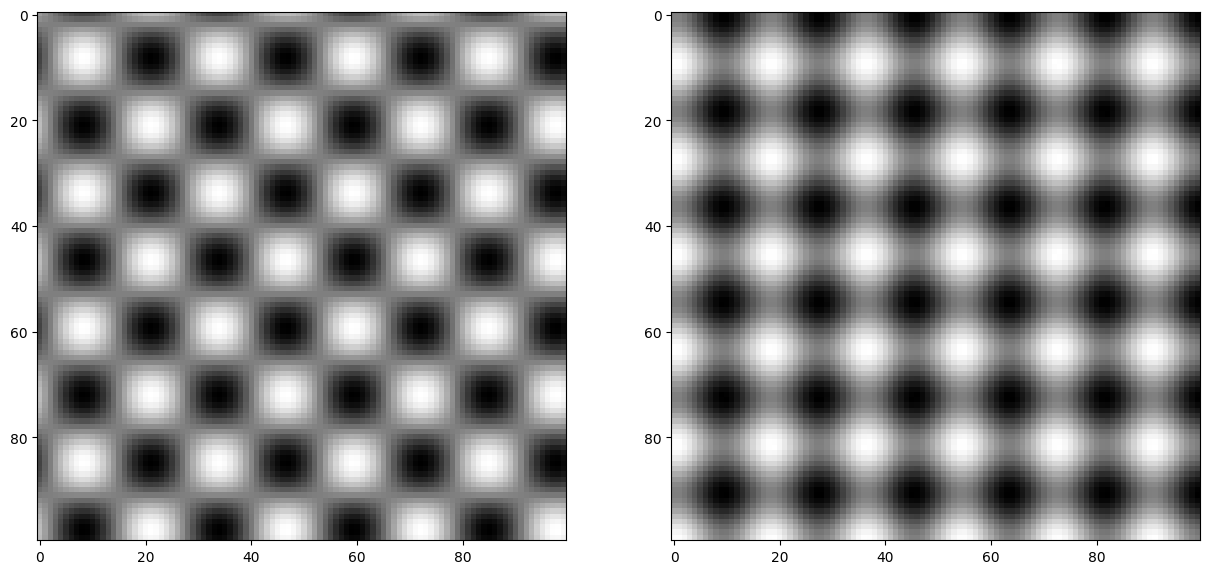

In [36]:
def demo():
    sines = np.sin(np.linspace(0, 20*np.pi, 256))
    stripes = np.outer(sines, sines)
    normal = rotate(stripes, 0, mode='edge')[100:200, 100:200]
    stripes = rotate(stripes, 45, mode='edge')[100:200, 100:200]
    plt.subplots(1,2, figsize=(15, 7))
    plt.subplot(121)
    plt.imshow(normal)
    plt.subplot(122)
    plt.imshow(stripes)
    plt.show()